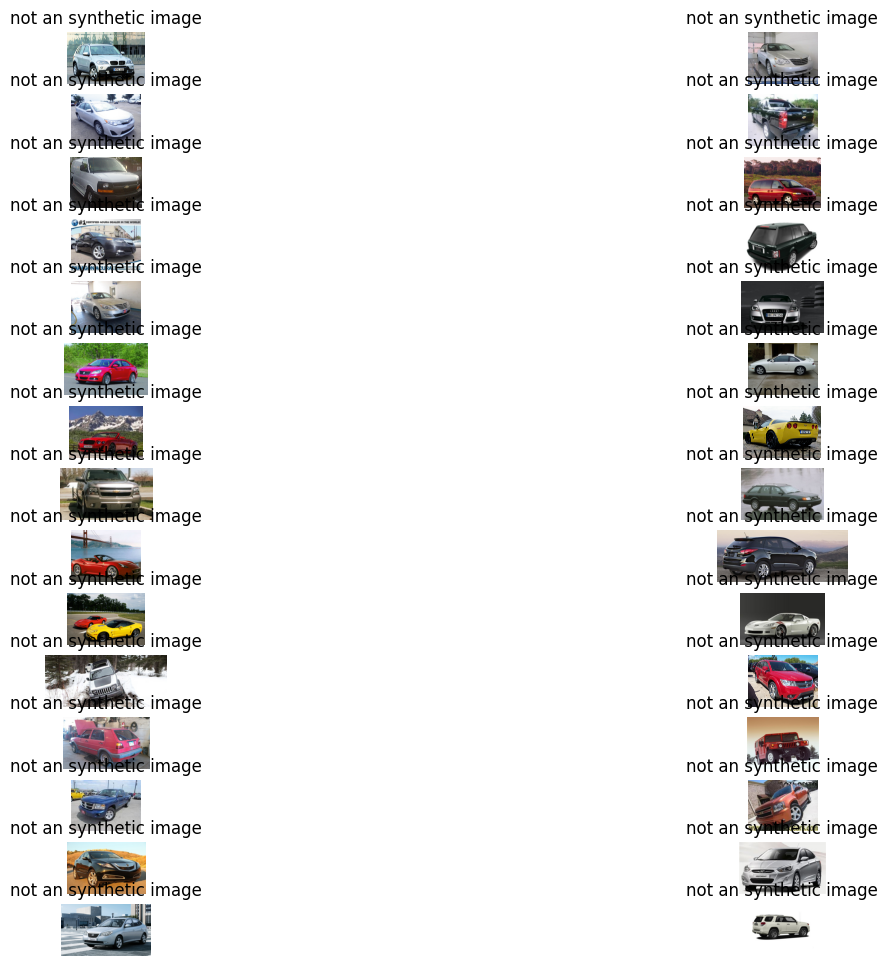

In [5]:
import os
import random
import clip
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Lade das CLIP-Modell
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Ordner mit den Bildern
image_folder = '../images/car/real'

# Prompts, die den Bildern zugeordnet werden sollen
prompts = ["synthetic image", "not an synthetic image"]

def load_images_from_folder(folder, preprocess):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
            images.append(image)
            filenames.append(filename)
    return images, filenames

def assign_labels_to_images(images, prompts, model):
    text_inputs = torch.cat([clip.tokenize(prompt).to(device) for prompt in prompts])
    image_labels = []

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)

        for image in images:
            image_features = model.encode_image(image)

            # Berechne die Kosinusähnlichkeit zwischen jedem Bild und jedem Text-Prompt
            similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            values, indices = similarities[0].topk(1)

            # Weise das Label mit der höchsten Übereinstimmung zu
            assigned_label = prompts[indices]
            image_labels.append(assigned_label)

    return image_labels

# Lade Bilder und weise Labels zu
images, filenames = load_images_from_folder(image_folder, preprocess)
image_labels = assign_labels_to_images(images, prompts, model)


# Zeige eine zufällige Auswahl von Bildern mit ihren Labels an
def show_labeled_images(filenames, image_labels):
    plt.figure(figsize=(16, 12))
    for i in range(min(len(filenames), 30)):  # Zeige bis zu 4 Bilder
        idx = random.randint(0, len(filenames) - 1)
        img = Image.open(os.path.join(image_folder, filenames[idx]))
        plt.subplot(15, 2, i + 1)
        plt.imshow(img)
        plt.title(f"{image_labels[idx]}")
        plt.axis("off")
    plt.show()

show_labeled_images(filenames, image_labels)


In [6]:
image_labels.count("synthetic image")

40